In [1]:
import numpy as np
import pandas as pd

import pymoo
from pymoo.core.problem import ElementwiseProblem, Problem

Przykładowe zadanie optymalizacyjne mieliśmy już podczas zajęć związanych z sieciami neuronowymi. Wtedy był to problem optymalizacji jednokryterialnej. Niestety często rzeczywiste problemy należy oceniać na więcej niż jednym kryterium i wówczas problem staje się bardziej złożonych. Sporo rozwiązań jest nieporównywalnych - nie możemy jednoznacznie wskazać które z nich jest lepsze. Wynikiem takiej optymalizacji nie będzie jedno rozwiązanie optymalne tylko zbiór rozwiązań pareto-optymalnych. Dla przykładu jeśli mamy wybrać dostawcę usług internetowych i oceniamy pod kątem prędkości i ceny to mając poniższą tabelkę:

In [2]:
df = pd.DataFrame({
    "cena": [30,35,40,40,45,50,70,200,50], 
    "prędkość":[100,200,150,300,450,550,220,300,340]})
display(df)

,cena,prędkość
0,30,100
1,35,200
2,40,150
3,40,300
4,45,450
5,50,550
6,70,220
7,200,300
8,50,340


Następujące alternatywy są niezdominowane i stanowią front pareto

In [3]:
# Front pareto wybiera rozwiązania, które są zawsze niegorsze niż inne
# Part 1: macierz 'dany dostawca ma cenę nie wyższą niż inni'
part_1 = np.less_equal.outer(df.cena.values, df.cena.values)

# display(part_1)

# Part 2: macierz 'czy dany dostawca ma prędkość nie niższą niż inni'
part_2 = np.greater_equal.outer(df['prędkość'].values, df['prędkość'].values)

# display(part_2)

part_3 = np.less.outer(df.cena.values, df.cena.values)

# display(part_3 | part_4)

part_4 = np.greater.outer(df['prędkość'].values,df['prędkość'].values)

dominated = part_1 & part_2 & ( part_3 | part_4 )
# display(dominated)

res = dominated.sum(0)==0
# display(res)

df[res]

,cena,prędkość
0,30,100
1,35,200
3,40,300
4,45,450
5,50,550


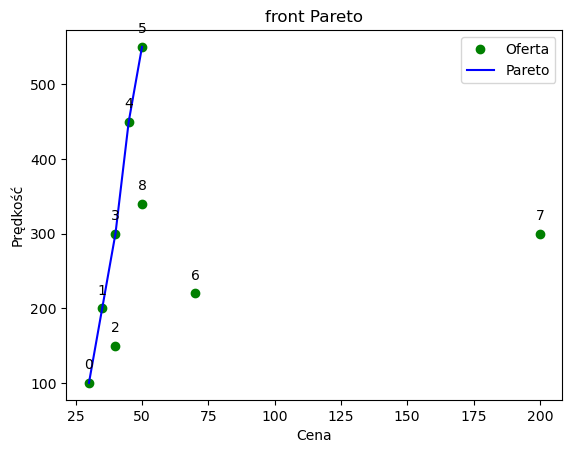

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot the data as dots
ax.plot(df['cena'], df['prędkość'], 'go', label='Oferta')  # 'ro' represents red dots
ax.plot(df[res]['cena'], df[res]['prędkość'], 'b', label='Pareto')

# Set labels and title
ax.set_xlabel('Cena')
ax.set_ylabel('Prędkość')
ax.set_title('front Pareto')

# Add a legend
ax.legend()

for i, row in df.iterrows():
    ax.annotate(i, (row['cena'], row['prędkość']), textcoords="offset points", xytext=(0,10), ha='center')
    # ax.annotate((i, row['cena'], row['prędkość']), (row['cena'], row['prędkość']), textcoords="offset points", xytext=(0,10), ha='center')
    


# Show the plot
plt.show()

Przykładowo opcja nr 2 jest zdominowana przez wariant 1, który przy niższej cenie oferuje lepszą prędkość. Jednak dla powyższych 5 alternatyw nie można wskazać zdominowanej

Do zadań optymalizacji wielokryterialnej bardzo dobrze nadają się algorytmy genetyczne. W swojej naturze działają one na zróżnicowanym zbiorze rozwiązań, z którego można wyciągnąć front pareto. Istnieją różne warianty algorytmów genetycznych dla optymalizacji wielokryterialnej, w których przekazujemy dodatkową informację preferencyjną, aby być w stanie porównywać warianty i skupić się na konkretnym obszarze frontu pareto, lub takie, które wymuszają, aby rozwiązania były równomiernie rozdystrybuowane po całym froncie.

Jednym z pakietów oferujących genetyczną optymalizację wielokryterialną jest pymoo. W ramach niego można korzystać z już gotowych poszczególnych etapów optymalizacji genetycznej jak i dopasować je poprzez implementację wybranych kroków.

In [5]:
from pymoo.operators.crossover.hux import HUX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems.single.knapsack import create_random_knapsack_problem

problem = create_random_knapsack_problem(30)


algorithm = GA(pop_size=200,
               sampling=BinaryRandomSampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination=('n_gen', 20),
               verbose=True)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      200 |  1.300000E+02 |  4.971950E+02 |             - |             -
     2 |      400 |  5.700000E+01 |  3.461950E+02 |             - |             -
     3 |      600 |  5.700000E+01 |  2.462000E+02 |             - |             -
     4 |      800 |  0.000000E+00 |  1.654450E+02 | -3.538000E+02 | -4.370000E+02
     5 |     1000 |  0.000000E+00 |  9.591000E+01 | -3.341667E+02 | -4.370000E+02
     6 |     1200 |  0.000000E+00 |  4.528000E+01 | -3.032000E+02 | -4.530000E+02
     7 |     1400 |  0.000000E+00 |  1.091500E+01 | -2.972818E+02 | -5.490000E+02
     8 |     1600 |  0.000000E+00 |  0.000000E+00 | -3.028700E+02 | -5.490000E+02
     9 |     1800 |  0.000000E+00 |  0.000000E+00 | -3.685000E+02 | -5.890000E+02
    10 |     2000 |  0.000000E+00 |  0.000000E+00 | -4.137900E+02 | -6.770000E+02
    11 |     2200 |  0.000000E+00 |  0.000000E+00 | -4.603100E+02 | -6.770000E+02
    12 |     240

Można skorzystać z gotowych problemów i gotowych rozwiązań, ale raczej nie przyczynia się to do lepszego zrozumienia dlatego najpierw zdefiniujmy problem plecakowy

In [6]:
class KnapsackProblem(ElementwiseProblem):
    def __init__(self, df, C):
        super().__init__(n_var=len(df), n_obj=1, n_ieq_constr=0)
        self.df = df
        self.C = C

    def _evaluate(self, x, out, *args, **kwargs):
        s = self.df['cap'][x].sum()
        if s > self.C:
            out["F"] = 1
        else:
            out["F"] = -self.df['val'][x].sum()
        

In [7]:
np.random.seed(42)
df = pd.DataFrame({'val': np.random.rand(50), 'cap': np.random.randint(1,10,50)})
df

,val,cap
0,0.374540,2
1,0.950714,2
2,0.731994,4
3,0.598658,8
4,0.156019,7
5,0.155995,9
6,0.058084,8
7,0.866176,5
8,0.601115,2
9,0.708073,5


In [8]:
problem = KnapsackProblem(df, 50)


algorithm = GA(pop_size=500,
               sampling=BinaryRandomSampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               verbose=True,
               seed=0)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      500 |  1.0000000000 |  1.0000000000
     2 |     1000 |  1.0000000000 |  1.0000000000
     3 |     1500 |  1.0000000000 |  1.0000000000
     4 |     2000 |  1.0000000000 |  1.0000000000
     5 |     2500 |  1.0000000000 |  1.0000000000
     6 |     3000 |  1.0000000000 |  1.0000000000
     7 |     3500 |  1.0000000000 |  1.0000000000
     8 |     4000 |  1.0000000000 |  1.0000000000
     9 |     4500 |  1.0000000000 |  1.0000000000
    10 |     5000 |  1.0000000000 |  1.0000000000
    11 |     5500 |  1.0000000000 |  1.0000000000
    12 |     6000 |  1.0000000000 |  1.0000000000
    13 |     6500 |  1.0000000000 |  1.0000000000
    14 |     7000 |  1.0000000000 |  1.0000000000
    15 |     7500 |  1.0000000000 |  1.0000000000
    16 |     8000 |  1.0000000000 |  1.0000000000
    17 |     8500 |  1.0000000000 |  1.0000000000
    18 |     9000 |  1.0000000000 |  1.0000000000
    19 |     9500 |  1.0000000000 |  1.0000000000


In [9]:
# display(problem.C)

In [10]:
res.X

array([ True,  True,  True, False, False, False, False,  True,  True,
        True, False, False, False,  True, False, False, False, False,
        True, False, False, False,  True, False,  True,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
       False, False,  True, False, False, False, False,  True, False,
        True, False,  True, False, False])

In [11]:
df[res.X].sum()

val    11.814856
cap    50.000000
dtype: float64

#### Zad 1
Nasza funkcja oceny ocenia jedno rozwiązanie na raz gdyż używamy ElementwiseProblem. Możemy jednak ocenić całe pokolenie na raz. Będzie to znacznie szybsze. Wykorzystaj funkcjonalność numpy i pandasa

In [12]:
import itertools
%load_ext line_profiler

# %%timeit
#  %lprun -f win_probability win_probability(df)

In [13]:
class KnapsackProblem(Problem):
    def __init__(self, df, C):
        super().__init__(n_var=len(df), n_obj=1, n_ieq_constr=0)
        self.df = df
        self.C = C

    def _evaluate(self, x, out, *args, **kwargs):
        # print(x)
        values = np.dot(x, self.df['val'].values)
        weights = np.dot(x, self.df['cap'].values)
        penalties = np.where(weights > self.C, (weights - self.C) * 1000, 0)

        objectives = -(values - penalties)
        out["F"] = objectives.reshape(-1, 1)

In [14]:
def testTime():
    problem = KnapsackProblem(df, 50)
    algorithm = GA(pop_size=500,
                sampling=BinaryRandomSampling(),
                crossover=HUX(),
                mutation=BitflipMutation(),
                eliminate_duplicates=True)

    res = minimize(problem,
                algorithm,
                termination=('n_gen', 100),
                verbose=True,
                seed=0)

In [15]:
# df

In [16]:
# %%timeit
testTime()

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      500 |  8.510074E+04 |  2.799048E+04
     2 |     1000 |  6.180603E+04 |  1.999150E+04
     3 |     1500 |  4.594896E+04 |  9.932941E+02
     4 |     2000 |  3.292970E+04 | -7.521948E+00
     5 |     2500 |  2.164644E+04 | -8.489075E+00
     6 |     3000 |  1.155515E+04 | -8.489075E+00
     7 |     3500 |  3.673843E+03 | -9.113780E+00
     8 |     4000 |  9.649324E+01 | -9.268728E+00
     9 |     4500 | -6.278407E+00 | -9.268728E+00
    10 |     5000 | -6.922031E+00 | -9.709450E+00
    11 |     5500 | -7.394139E+00 | -9.709450E+00
    12 |     6000 | -7.879333E+00 | -1.006053E+01
    13 |     6500 | -8.298002E+00 | -1.024524E+01
    14 |     7000 | -8.648843E+00 | -1.091264E+01
    15 |     7500 | -8.961034E+00 | -1.091264E+01
    16 |     8000 | -9.279144E+00 | -1.124052E+01
    17 |     8500 | -9.579549E+00 | -1.124052E+01
    18 |     9000 | -9.809069E+00 | -1.133886E+01
    19 |     9500 | -1.003704E+01 | -1.142271E+01


In [17]:
df[res.X].sum()

val    11.814856
cap    50.000000
dtype: float64

In [18]:
df[res.X]

,val,cap
0,0.374540,2
1,0.950714,2
2,0.731994,4
7,0.866176,5
8,0.601115,2
9,0.708073,5
13,0.212339,1
18,0.431945,1
22,0.292145,1
24,0.456070,3


Trochę to trwało zanim zaczęły się generować akceptowalne rozwiązania - z capacity nie większym niż pojemność naszego plecaka. Postaramy się teraz zaingerować w poszczególne elementy algorytmu, aby szybciej uzyskać lepsze wyniki

Nasze ograniczenie jest na tyle proste, że można je łatwo wyrazić w formie nierówności, które są natywnie wspierane przez pymoo. Musimy w tym celu zmodyfikować definicję problemu

In [19]:
class KnapsackProblemConstrained(ElementwiseProblem):
    def __init__(self, df, C):
        super().__init__(n_var=len(df), n_obj=1, n_ieq_constr=1)
        self.df = df
        self.C = C

    def _evaluate(self, x, out, *args, **kwargs):
        s = self.df['cap'][x].sum()
        if s > self.C:
            out["F"] = 1
        else:
            out["F"] = -self.df['val'][x].sum()
        out["G"] = s - self.C
        

In [20]:
problemC = KnapsackProblemConstrained(df, 50)
algorithm = GA(pop_size=500,
               sampling=BinaryRandomSampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               eliminate_duplicates=True)


res = minimize(problemC,
               algorithm,
               termination=('n_gen', 200),
               verbose=True,
               seed=0)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      500 |  2.800000E+01 |  8.511200E+01 |             - |             -
     2 |     1000 |  2.200000E+01 |  6.201800E+01 |             - |             -
     3 |     1500 |  6.0000000000 |  4.589200E+01 |             - |             -
     4 |     2000 |  0.000000E+00 |  3.287000E+01 | -5.898669E+00 | -6.924837E+00
     5 |     2500 |  0.000000E+00 |  2.115200E+01 | -5.431609E+00 | -6.924837E+00
     6 |     3000 |  0.000000E+00 |  1.122400E+01 | -5.549265E+00 | -9.020056E+00
     7 |     3500 |  0.000000E+00 |  3.3800000000 | -5.455921E+00 | -9.020056E+00
     8 |     4000 |  0.000000E+00 |  0.0300000000 | -5.440005E+00 | -9.020056E+00
     9 |     4500 |  0.000000E+00 |  0.000000E+00 | -6.456785E+00 | -9.075306E+00
    10 |     5000 |  0.000000E+00 |  0.000000E+00 | -7.189458E+00 | -1.005429E+01
    11 |     5500 |  0.000000E+00 |  0.000000E+00 | -7.766529E+00 | -1.005830E+01
    12 |     600

In [21]:
df[res.X].sum()

val    11.886649
cap    50.000000
dtype: float64

Często mamy jednak do czynienia z bardziej złożonymi ograniczeniami, których nie idzie wyrazić w tak prosty sposób. Warto wtedy skorzystać z operatora naprawy, który jak sama nazwa wskazuje będzie naprawiał niepoprawne rozwiązania 

#### Zad 2
Zaimplementuj taki operator, który zadba o to, żeby nie przekraczać pojemności plecaka a jednocześnie nie będzie się zbyt mocno różnił od pierwotnego rozwiązania. Zwróć uwagę, że tutaj rozważamy całe pokolenie na raz w zmiennej Z

In [22]:
# from pymoo.core.repair import Repair


# class ConsiderMaximumWeightRepair(Repair):

#     def _do(self, problem, Z, **kwargs):
#         maxCapacity = problem.C
#         weights = (Z * problem.df['cap'].values).sum(axis=1)

#         for i in range(len(Z)):
            # pass # now repair each indvidiual i

#         return Z

In [23]:
from pymoo.core.repair import Repair


class ConsiderMaximumWeightRepair(Repair):

    def _do(self, problem, Z, **kwargs):
        maxCapacity = problem.C
        weights = problem.df['cap'].values
        values = problem.df['val'].values
        value_weight_ratio = values / weights

        for i in range(len(Z)):
            while np.dot(Z[i], weights) > maxCapacity:
                current_items = np.where(Z[i] == 1)[0]

                if(len(current_items) == 0):
                    break

                ratio_selected = value_weight_ratio[current_items]

                item_remove = current_items[np.argmin(ratio_selected)]
                Z[i, item_remove] = 0
                
        return Z

In [24]:
algorithm = GA(pop_size=200,
               sampling=BinaryRandomSampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               repair=ConsiderMaximumWeightRepair(),
               eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               verbose=True,
               seed=0)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 | -8.142320E+00 | -1.148332E+01
     2 |      400 | -9.243459E+00 | -1.148332E+01
     3 |      600 | -9.872161E+00 | -1.148332E+01
     4 |      800 | -1.037837E+01 | -1.154895E+01
     5 |     1000 | -1.077645E+01 | -1.184110E+01
     6 |     1200 | -1.107121E+01 | -1.184110E+01
     7 |     1400 | -1.120115E+01 | -1.188665E+01
     8 |     1600 | -1.130666E+01 | -1.188665E+01
     9 |     1800 | -1.138413E+01 | -1.188665E+01
    10 |     2000 | -1.143333E+01 | -1.188665E+01
    11 |     2200 | -1.146848E+01 | -1.188665E+01
    12 |     2400 | -1.150134E+01 | -1.188665E+01
    13 |     2600 | -1.152235E+01 | -1.188665E+01
    14 |     2800 | -1.153692E+01 | -1.188665E+01
    15 |     3000 | -1.154764E+01 | -1.188665E+01
    16 |     3200 | -1.155894E+01 | -1.188665E+01
    17 |     3400 | -1.156478E+01 | -1.188665E+01
    18 |     3600 | -1.157003E+01 | -1.188665E+01
    19 |     3800 | -1.157427E+01 | -1.188665E+01


Zmieńmy nasz zestaw danych na trochę większy

In [25]:
np.random.seed(42)
df = pd.DataFrame({'val': np.random.rand(500), 'cap': np.random.randint(1,10,500)})
df

,val,cap
0,0.374540,6
1,0.950714,1
2,0.731994,9
3,0.598658,1
4,0.156019,5
...,...,...
495,0.353352,4
496,0.583656,6
497,0.077735,8
498,0.974395,1


In [26]:
problem = KnapsackProblem(df, 50)
algorithm = GA(pop_size=200,
               sampling=BinaryRandomSampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               repair=ConsiderMaximumWeightRepair(),
               eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               verbose=True,
               seed=0)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 | -2.548979E+01 | -2.903530E+01
     2 |      400 | -2.696013E+01 | -2.994796E+01
     3 |      600 | -2.793814E+01 | -3.068094E+01
     4 |      800 | -2.887334E+01 | -3.140991E+01
     5 |     1000 | -2.962280E+01 | -3.140991E+01
     6 |     1200 | -3.027338E+01 | -3.173574E+01
     7 |     1400 | -3.085297E+01 | -3.218911E+01
     8 |     1600 | -3.133111E+01 | -3.266664E+01
     9 |     1800 | -3.177581E+01 | -3.284465E+01
    10 |     2000 | -3.216558E+01 | -3.288122E+01
    11 |     2200 | -3.243794E+01 | -3.302248E+01
    12 |     2400 | -3.264623E+01 | -3.308681E+01
    13 |     2600 | -3.277631E+01 | -3.313120E+01
    14 |     2800 | -3.288339E+01 | -3.313120E+01
    15 |     3000 | -3.292909E+01 | -3.313120E+01
    16 |     3200 | -3.295377E+01 | -3.313120E+01
    17 |     3400 | -3.298157E+01 | -3.313120E+01
    18 |     3600 | -3.300059E+01 | -3.313120E+01
    19 |     3800 | -3.301182E+01 | -3.313120E+01


#### Zad 3
Warto zaingerować w etap tworzenia inicjalnej populacji. Po pierwsze nie ma sensu wkładać do plecaka połowy dostępnych obiektów, skoro pojemności mamy tylko na kilkanaście. Po drugie zamiast wybierać je losowo warto wybrać te, które mają korzystny stosunek jakości do wagi. Zaimplentuj taką funkcję

In [27]:
from pymoo.core.sampling import Sampling

# Nie ingerujemy w listę przedmiotów możliwych do włożenia do plecaka, tylko w liczbę jedynek, które są przyznawane na początku. 
# Dzięki temu algorytm genetyczny nie próbuje upchać przedmiotów wagi 300 do plecaka pojemności 30

class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):

        # Stara wersja
        # X = np.full((n_samples, problem.n_var), False, dtype=bool)

        estimated_items_probability = min(1, int(problem.C / problem.df['cap'].values.sum()))
        
        # estimated_probability = estimated_items_include/problem.C
        
        X = np.random.choice([True, False], size=(n_samples, problem.n_var), p=[estimated_items_probability, 1 - estimated_items_probability])

            
        return X

In [28]:
algorithm = GA(pop_size=200,
               sampling=MySampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               repair=ConsiderMaximumWeightRepair(),
               eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               verbose=True,
               seed=0)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        1 |  0.000000E+00 | -0.000000E+00
     2 |      201 | -7.601898E-01 | -2.553555E+00
     3 |      401 | -1.857023E+00 | -4.928504E+00
     4 |      601 | -3.199340E+00 | -6.709402E+00
     5 |      801 | -4.735361E+00 | -7.748112E+00
     6 |     1001 | -6.222024E+00 | -9.764585E+00
     7 |     1201 | -7.536098E+00 | -1.026654E+01
     8 |     1401 | -8.698198E+00 | -1.088589E+01
     9 |     1601 | -9.731589E+00 | -1.271060E+01
    10 |     1801 | -1.069178E+01 | -1.365600E+01
    11 |     2001 | -1.175019E+01 | -1.531004E+01
    12 |     2201 | -1.292542E+01 | -1.622505E+01
    13 |     2401 | -1.416653E+01 | -1.766262E+01
    14 |     2601 | -1.540846E+01 | -1.893639E+01
    15 |     2801 | -1.668035E+01 | -1.931309E+01
    16 |     3001 | -1.785649E+01 | -2.085163E+01
    17 |     3201 | -1.904727E+01 | -2.221189E+01
    18 |     3401 | -2.017991E+01 | -2.333526E+01
    19 |     3601 | -2.121621E+01 | -2.333526E+01


#### Zad 4
Przyjrzyjmy się jeszcze jak działa mutacja i krzyżowanie

In [29]:
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation

class MyMutation(Mutation):
    def _do(self, problem, X, **kwargs):
        for i in range(X.shape[0]):
            mutate = np.random.randint(0, problem.n_var)
            X[i, mutate] = not X[i, mutate]
        return X
    

class MyCrossover(Crossover):
    def __init__(self):
        super().__init__(2, 1)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape

        _X = np.full((self.n_offsprings, n_matings, problem.n_var), False, dtype=bool)

        for k in range(n_matings):
            p1, p2 = X[0, k], X[1, k]
            
            for j in range(n_var):
                _X[0, k, j] = p1[j] if np.random.rand() < 0.5 else p2[j]

        return _X

Przejdziemy teraz do optymalizacji wielokryterialnej. Jedno kryterium zostanie takie jakie było, drugim będzie waga plecaka

In [30]:
class KnapsackProblemMulti(Problem):
    def __init__(self, df, C):
        super().__init__(n_var=len(df), n_obj=2, n_ieq_constr=0)
        self.df = df
        self.C = C

    def _evaluate(self, x, out, *args, **kwargs):
        f2 = (x * self.df['cap'].values).sum(1)
        f1 = np.where(f2 <= self.C, -(x * self.df['val'].values).sum(1), 1)
        out["F"] = [f1, f2]

NSGA2 jest jednym z najpopularniejszych odmian algorytmów genetycznych do optymalizacji wielokryterialnej, nie jest jednak jedynym

In [31]:
from pymoo.algorithms.moo.nsga2 import NSGA2

In [32]:
# Zmieniliśmy crossover i mutate na nasze
problem = KnapsackProblemMulti(df, 50)
algorithm = NSGA2(pop_size=200,
               sampling=MySampling(),
               crossover=MyCrossover(),
               mutation=MyMutation(),
               repair=ConsiderMaximumWeightRepair(),
               eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               verbose=True,
               seed=0)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        1 |      1 |             - |             -
     2 |      201 |      2 |  1.0000000000 |         ideal
     3 |      401 |      7 |  0.6282304308 |         ideal
     4 |      601 |      8 |  0.3825168017 |         ideal
     5 |      801 |     12 |  0.2885448949 |         ideal
     6 |     1001 |     12 |  0.2588352141 |         ideal
     7 |     1201 |     13 |  0.0481652945 |         ideal
     8 |     1401 |     15 |  0.0101772513 |         ideal
     9 |     1601 |     17 |  0.1621708902 |         ideal
    10 |     1801 |     17 |  0.1715820613 |         ideal
    11 |     2001 |     21 |  0.0250555860 |             f
    12 |     2201 |     19 |  0.0472381730 |         ideal
    13 |     2401 |     19 |  0.1921692444 |         ideal
    14 |     2601 |     18 |  0.0085597297 |             f
    15 |     2801 |     21 |  0.0135830046 |             f
    16 |     3001 |     21 |  0.0588857866 |         ide

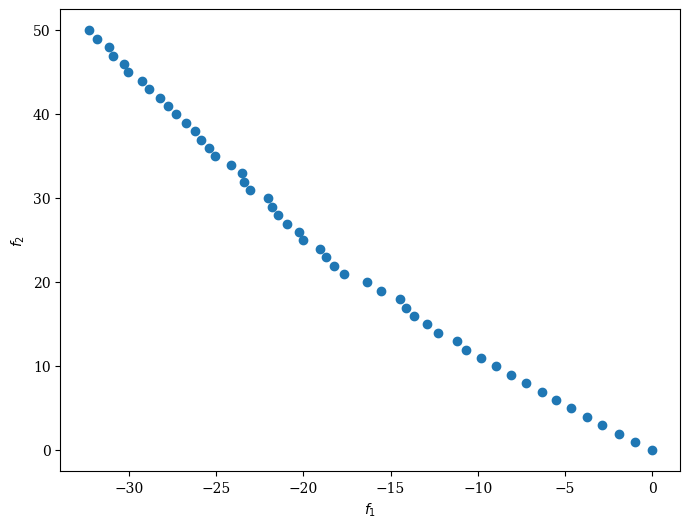

In [33]:
from pymoo.visualization.scatter import Scatter
Scatter().add(res.F).show()

In [34]:
res.X

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False,  True, False],
       [False,  True, False, ..., False,  True, False],
       [False,  True, False, ..., False,  True, False]])

In [35]:
res.F

array([[ -0.        ,   0.        ],
       [ -0.99005385,   1.        ],
       [ -2.88736439,   3.        ],
       [ -8.12482832,   9.        ],
       [ -3.73040507,   4.        ],
       [-12.27688921,  14.        ],
       [ -7.23654831,   8.        ],
       [-14.45473517,  18.        ],
       [ -1.87972918,   2.        ],
       [-27.30727481,  40.        ],
       [-26.70508656,  39.        ],
       [-25.85186994,  37.        ],
       [ -8.9577283 ,  10.        ],
       [-10.67884333,  12.        ],
       [-23.03966027,  31.        ],
       [-24.15252871,  34.        ],
       [-13.64707714,  16.        ],
       [-27.76075093,  41.        ],
       [-23.40959143,  32.        ],
       [-26.22132163,  38.        ],
       [-21.80580689,  29.        ],
       [-12.89383191,  15.        ],
       [ -4.65836848,   5.        ],
       [-19.05918599,  24.        ],
       [-23.52457166,  33.        ],
       [ -6.33643803,   7.        ],
       [-11.2198521 ,  13.        ],
 

In [36]:
from pymoo.algorithms.moo.rnsga2 import RNSGA2

In [37]:
algorithm = RNSGA2(ref_points=np.array([[-10, 30]]),
               pop_size=200,
               sampling=MySampling(),
               crossover=HUX(),
               mutation=BitflipMutation(),
               repair=ConsiderMaximumWeightRepair(),
               eliminate_duplicates=True)


res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               verbose=True,
               seed=0)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        1 |      1 |             - |             -
     2 |      201 |      8 |  1.0000000000 |         ideal
     3 |      401 |      9 |  0.4581504676 |         ideal
     4 |      601 |     17 |  0.3531891372 |         ideal
     5 |      801 |     20 |  0.0402115897 |         ideal
     6 |     1001 |     21 |  0.1635274095 |         ideal
     7 |     1201 |     22 |  0.1811311482 |         ideal
     8 |     1401 |     22 |  0.0599785150 |         ideal
     9 |     1601 |     18 |  0.0635805774 |         ideal
    10 |     1801 |     24 |  0.0848122119 |         ideal
    11 |     2001 |     26 |  0.0919508470 |         ideal
    12 |     2201 |     25 |  0.0250051166 |             f
    13 |     2401 |     25 |  0.1187534245 |         ideal
    14 |     2601 |     25 |  0.0155028838 |             f
    15 |     2801 |     27 |  0.0085981827 |         ideal
    16 |     3001 |     31 |  0.0461263377 |         ide

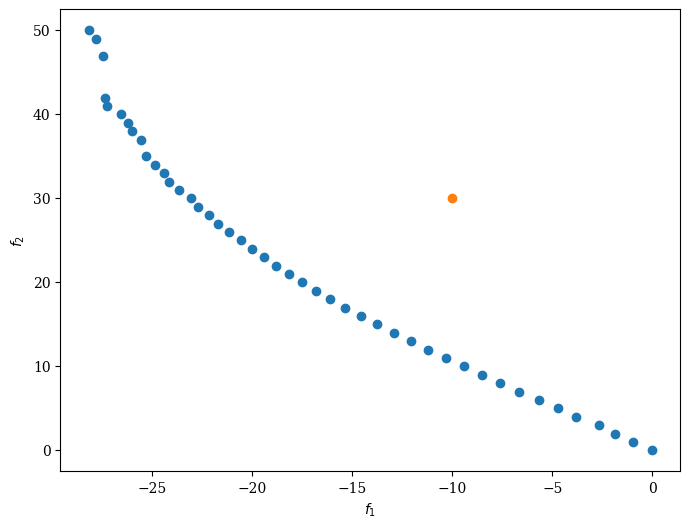

In [38]:
Scatter().add(res.F).add(np.array([[-10,30]]), label="ref_points").show()

## Zad 5
Rozwiąż zadanie optymalizacji wielokryterialnej stojące przed firmą kurierską. Mamy do dostarczenia przesyłki. Z jednej strony chcemy je dostarczyć jak najszybciej, z drugiej chcemy żeby to kosztowało jak najmniej. Dane wejściowe:
 - df -- zbiór zamówień z ich lokalizacją i wagą
 - t -- liczba dostępnych ciężarówek
 - p -- zbiór stacji benzynowych z lokalizacją i ceną za litr
 - fp -- funkcja określająca spalanie na 100km przy założonej wadze
 - cp -- pojemność baku
 - b -- lokalizacja bazy
 - s -- średnia prędkość w km/h
 - m -- godzinna stawka kierowcy

Na koniec wszystkie ciężarówki muszą wrócić do bazy i mieć przynajmniej 50% paliwa w baku. Wszystkie paczki muszą być dostarczone w wymaganym okresie. Pojemność ciężarówek jest nieskończona. Do obliczania dystansu użyj metryki miejskiej, współrzędne są podane w kilometrach. Ciężarówka nie musi brać całego załadunku na raz, może wracać do bazy żeby zabrać kolejne paczki

Generalnie zadanie wykonuje się całe na raz, nie w kawałkach (bez jekiegoś zewnętrznego optymalizowania metryk spalania, czy coś w ten deseń)

Na pewno jednym z inputów będzie wektor punktów, a w nim informacja który kierowca i jako który punkt podbierze dane zamówienie. Chcemy mieć gwarancję przejrzenia wszystkich możliwych kombinacji. (przykładowy indeks: indeks kierowcy*100 + jego kolejność

Te dodatkowe parametry w stylu spalanie, pojemnośc baku i stacje benzynowe potrzebne sa do funkcji evaluate, czyli bardziej po to,żeby zadecydować, czy dany kierowca fizycznie jest w stanie wziąć udział w kolejnej rundzie, czy musi wracać do bazy.

Paliwo liczyć w funkcji repair. Jeżeli kierowca nie jest w stanie nigdzie dojechać, to żeby jechał na najlepszą stację. 

Algorytm janusza wybierający stację ma być zaimplementowany w repair, albo w genetycznym, żeby był w stanie wybrać optymalną stację na danym etapie podróży. Generalnie nie może jechać po prostu do najbliższej stacji.





# Próba 1

In [39]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cityblock
from itertools import permutations

# Generowanie danych wejściowych
np.random.seed(42)
n_orders = 4
n_trucks = 2
n_stations = 10

# Zamówienia: lokalizacja i waga
df_orders = pd.DataFrame({
    "latitude": np.random.randn(n_orders) * 50,
    "longitude": np.random.randn(n_orders) * 50,
    "mass": np.random.rand(n_orders) * 10
})

# Stacje benzynowe: lokalizacja i cena za litr
df_stations = pd.DataFrame({
    "latitude": np.random.randn(n_stations) * 50,
    "longitude": np.random.randn(n_stations) * 50,
    "price": np.random.rand(n_stations) * 2 + 5
})

# Parametry
fuel_consumption_per_100km = lambda m: m  # Spalanie na 100km w zależności od masy
fuel_tank_capacity = 150  # Pojemność baku
base_location = np.array([0, 0])  # Lokalizacja bazy
average_speed = 40  # Średnia prędkość w km/h
driver_hourly_rate = 50  # Godzinna stawka kierowcy

In [40]:
df_orders.head()

,latitude,longitude,mass
0,24.835708,-11.707669,0.205845
1,-6.913215,-11.706848,9.699099
2,32.384427,78.960641,8.324426
3,76.151493,38.371736,2.123391


In [41]:
df_stations.head()

,latitude,longitude,price
0,-23.170885,73.282438,6.368466
1,-23.286488,-11.288815,5.880305
2,12.098114,3.376410,5.244076
3,-95.664012,-71.237409,5.990354
4,-86.245892,-27.219136,5.068777


In [42]:
import numpy as np
from scipy.spatial.distance import cityblock
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem

In [43]:
def fuel_consumption_per_100km(mass):
    return mass

In [44]:
def calculate_fuel_cost(distance, mass, price_per_litre):
    litres_needed = (distance / 100) * fuel_consumption_per_100km(mass)
    return litres_needed * price_per_litre

In [45]:
def find_nearest_fuel_station(location, df_stations):
    min_distance = np.inf
    nearest_station_price = 0
    for _, station in df_stations.iterrows():
        station_location = np.array([station['latitude'], station['longitude']])
        distance = cityblock(location, station_location)
        if distance < min_distance:
            min_distance = distance
            nearest_station_price = station['price']
    return nearest_station_price

In [46]:
class DeliveryOptimizationProblem(ElementwiseProblem):
    def __init__(self, df_orders, df_stations, base_location, trucks, fuel_capacity, average_speed, hourly_wage, fuel_consumption_function):
        super().__init__(n_var=len(df_orders) * 2,
                         n_obj=2,
                         xl=0, xu=(n_trucks - 1) * 100 + len(df_orders) - 1,
                         elementwise_evaluation=True)
        self.df_orders = df_orders
        self.df_stations = df_stations
        self.base_location = base_location
        self.trucks = trucks
        self.fuel_capacity = fuel_capacity
        self.average_speed = average_speed
        self.hourly_wage = hourly_wage
        self.fp = fuel_consumption_function 

    def _evaluate(self, x, out, *args, **kwargs):
        total_time = 0
        total_cost = 0

        truck_routes = {truck_id: [] for truck_id in range(self.trucks)}
        for order_index in range(len(x) // 2):
            truck_id = x[order_index * 2] // 100
            if truck_id < 0 or truck_id >= self.trucks:
                truck_id = max(0, min(truck_id, self.trucks - 1))

            truck_routes[truck_id].append(order_index)

        for truck_id, route in truck_routes.items():
            current_location = self.base_location
            fuel_remaining = self.fuel_capacity
            for order_id in route:
                order_location = self.df_orders.iloc[order_id][['latitude', 'longitude']].values
                distance = cityblock(current_location, order_location)
                
                time = distance / self.average_speed
                fuel_consumed = self.fp(self.df_orders.iloc[order_id]['mass']) * (distance / 100)
                
                if fuel_remaining < fuel_consumed:
                    nearest_station_price = find_nearest_fuel_station(current_location, self.df_stations)
                    total_cost += (self.fuel_capacity - fuel_remaining) * nearest_station_price
                    fuel_remaining = self.fuel_capacity
                
                fuel_remaining -= fuel_consumed
                total_time += time
                total_cost += distance * self.hourly_wage / self.average_speed
                
                current_location = order_location

            distance_back_to_base = cityblock(current_location, self.base_location)
            total_time += distance_back_to_base / self.average_speed

        out["F"] = [total_time, total_cost]

In [47]:
problem = DeliveryOptimizationProblem(df_orders=df_orders,
                                      df_stations=df_stations,
                                      base_location=base_location,
                                      trucks=n_trucks,
                                      fuel_capacity=fuel_tank_capacity,
                                      average_speed=average_speed,
                                      hourly_wage=driver_hourly_rate,
                                      fuel_consumption_function=fuel_consumption_per_100km)

In [48]:
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation

In [49]:
class RandomOrderSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        samples = np.zeros((n_samples, problem.n_var), dtype=int)
        for i in range(n_samples):
            for j in range(problem.n_var):
                truck_id = j // 100
                samples[i, j] = truck_id * 100 + np.random.choice(len(problem.df_orders))
        return samples

In [50]:
class OrderCrossover(Crossover):
    def __init__(self):
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):
        n_matings, _, n_vars = X.shape
        offspring = np.empty((n_matings * 2, n_vars), dtype=int)

        for k in range(n_matings):
            p1, p2 = X[k, 0, :], X[k, 1, :]

            idx = np.random.choice(n_vars, 2, replace=False)
            start, end = min(idx), max(idx)

            o1, o2 = p1.copy(), p2.copy()
            o1[start:end+1], o2[start:end+1] = p2[start:end+1], p1[start:end+1]

            offspring[2 * k, :] = o1
            offspring[2 * k + 1, :] = o2

        return offspring

def fill_from_parent(offspring, parent, start, end):
    n_vars = len(parent)
    pos = 0
    for gene in parent:
        if pos == start:
            pos = end + 1
        if gene not in offspring[start:end+1] and pos < len(offspring):
            offspring[pos] = gene
            pos += 1

In [51]:
class SwapMutation(Mutation):
    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            if np.random.rand() < 0.1:
                idx = np.random.choice(len(X[i]), 2, replace=False)
                X[i][idx[0]], X[i][idx[1]] = X[i][idx[1]], X[i][idx[0]]
        return X

In [93]:
algorithm = NSGA2(
    pop_size=100,
    sampling=RandomOrderSampling(),
    crossover=MyCrossover(),
    mutation=SwapMutation(),
    eliminate_duplicates=True
)

In [94]:
result = minimize(
    problem,
    algorithm,
    ('n_gen', 200),
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      200 |    100 |  0.000000E+00 |             f
     3 |      300 |    100 |  0.000000E+00 |             f
     4 |      400 |    100 |  0.000000E+00 |             f
     5 |      500 |    100 |  0.000000E+00 |             f
     6 |      600 |    100 |  0.000000E+00 |             f
     7 |      700 |    100 |  0.000000E+00 |             f
     8 |      800 |    100 |  0.000000E+00 |             f
     9 |      900 |    100 |  0.000000E+00 |             f
    10 |     1000 |    100 |  0.000000E+00 |             f
    11 |     1100 |    100 |  0.000000E+00 |             f
    12 |     1200 |    100 |  0.000000E+00 |             f
    13 |     1300 |    100 |  0.000000E+00 |             f
    14 |     1400 |    100 |  0.000000E+00 |             f
    15 |     1500 |    100 |  0.000000E+00 |             f
    16 |     1600 |    100 |  0.000000E+00 |            

# Próba 2

In [55]:
from pymoo.core.population import Population

def custom_sampling(problem, pop_size, **kwargs):
    population = Population.new("X", np.empty((pop_size, problem.n_var)))

    for i in range(pop_size):
        individual = []
        for _ in range(problem.trucks):
            orders = np.arange(len(problem.df_orders))
            np.random.shuffle(orders)
            individual.extend(orders.tolist())
        population[i].set("X", np.array(individual))
    
    return population

In [56]:
def custom_crossover(parent1, parent2, **kwargs):
    size = min(len(parent1), len(parent2))
    cxpoint1, cxpoint2 = np.sort(np.random.choice(range(size), 2, replace=False))
    child1 = [None]*size
    child2 = [None]*size
    child1[cxpoint1:cxpoint2] = parent1[cxpoint1:cxpoint2]
    child2[cxpoint1:cxpoint2] = parent2[cxpoint1:cxpoint2]
    fill_child(child1, parent2, cxpoint1, cxpoint2)
    fill_child(child2, parent1, cxpoint1, cxpoint2)
    return child1, child2

def fill_child(child, parent, start, end):
    child_size = len(child)
    parent_size = len(parent)
    child_pos = end
    parent_pos = end
    while None in child:
        if parent[parent_pos % parent_size] not in child:
            child[child_pos % child_size] = parent[parent_pos % parent_size]
            child_pos += 1
        parent_pos += 1


In [57]:
def custom_mutation(individual, **kwargs):
    mut_point1, mut_point2 = np.random.choice(len(individual), 2, replace=False)
    individual[mut_point1], individual[mut_point2] = individual[mut_point2], individual[mut_point1]
    return individual

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3

algorithm = NSGA3(
    pop_size=40,
    n_offsprings=1,
    sampling=lambda problem, pop_size, **kwargs: custom_sampling(problem, pop_size),
    crossover=lambda p1, p2, **kwargs: custom_crossover(p1, p2),
    mutation=lambda ind, **kwargs: custom_mutation(ind),
    eliminate_duplicates=True,
    ref_dirs=None
)

In [ ]:
termination = {'n_gen': 100}

res = minimize(problem,
               algorithm,
               termination=termination,
               seed=1,
               verbose=True)

In [60]:
print(f"Pareto front - {len(res.F)}")
for i in range(len(res.X)):
    print(f"Rozwiązanie {i+1}: czas = {res.F[i][0]}, koszt = {res.F[i][1]}")

Pareto front - 45
Rozwiązanie 1: czas = -0.0, koszt = 0.0
Rozwiązanie 2: czas = -0.9500619670508049, koszt = 1.0
Rozwiązanie 3: czas = -2.6511582097034907, koszt = 3.0
Rozwiązanie 4: czas = -1.8769477143457332, koszt = 2.0
Rozwiązanie 5: czas = -10.324539207801005, koszt = 11.0
Rozwiązanie 6: czas = -11.212243390559305, koszt = 12.0
Rozwiązanie 7: czas = -4.720633691718973, koszt = 5.0
Rozwiązanie 8: czas = -14.556647628143375, koszt = 16.0
Rozwiązanie 9: czas = -12.070656142402317, koszt = 13.0
Rozwiązanie 10: czas = -25.58952130946912, koszt = 37.0
Rozwiązanie 11: czas = -16.82170698654467, koszt = 19.0
Rozwiązanie 12: czas = -12.921792813919172, koszt = 14.0
Rozwiązanie 13: czas = -16.129811788851974, koszt = 18.0
Rozwiązanie 14: czas = -15.358844608897414, koszt = 17.0
Rozwiązanie 15: czas = -20.587330511083138, koszt = 25.0
Rozwiązanie 16: czas = -17.512644724647135, koszt = 20.0
Rozwiązanie 17: czas = -27.46654049595759, koszt = 47.0
Rozwiązanie 18: czas = -18.185163180724174, ko

# Próba 3

In [76]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cityblock
from itertools import permutations, combinations

# Generowanie danych wejściowych
np.random.seed(42)
n_orders = 4
n_trucks = 2
n_stations = 10

# Zamówienia: lokalizacja i waga
df_orders = pd.DataFrame({
    "latitude": np.random.randn(n_orders) * 50,
    "longitude": np.random.randn(n_orders) * 50,
    "mass": np.random.rand(n_orders) * 10
})

# Stacje benzynowe: lokalizacja i cena za litr
df_stations = pd.DataFrame({
    "latitude": np.random.randn(n_stations) * 50,
    "longitude": np.random.randn(n_stations) * 50,
    "price": np.random.rand(n_stations) * 2 + 5
})

# Parametry
fuel_consumption_per_100km = lambda m: m  # Spalanie na 100km w zależności od masy
fuel_tank_capacity = 150  # Pojemność baku
base_location = np.array([0, 0])  # Lokalizacja bazy
average_speed = 40  # Średnia prędkość w km/h
driver_hourly_rate = 50  # Godzinna stawka kierowcy

# Funkcja oceny (evaluate)
def evaluate(route, df_orders, df_stations, fuel_consumption_per_100km, fuel_tank_capacity,
             base_location, average_speed, driver_hourly_rate):
    total_cost = 0
    total_time = 0
    fuel_level = fuel_tank_capacity

    current_location = base_location

    for i in route:
        if i >= 0:
            order_location = df_orders.iloc[i][['latitude', 'longitude']].values
            order_mass = df_orders.iloc[i]['mass']
            distance = cityblock(current_location, order_location)
            travel_time = distance / average_speed
            fuel_needed = (fuel_consumption_per_100km(order_mass) / 100) * distance
        else:
            station_index = -i - 1
            station_location = df_stations.iloc[station_index][['latitude', 'longitude']].values
            distance = cityblock(current_location, station_location)
            travel_time = distance / average_speed
            fuel_needed = 0 

        if fuel_level < fuel_needed:
            return np.inf, np.inf

        fuel_level -= fuel_needed
        total_cost += travel_time * driver_hourly_rate

        if i < 0:
            fuel_to_fill = fuel_tank_capacity - fuel_level
            fuel_cost = fuel_to_fill * df_stations.iloc[station_index]['price']
            total_cost += fuel_cost
            fuel_level = fuel_tank_capacity 

        total_time += travel_time
        current_location = order_location if i >= 0 else station_location

    distance_to_base = cityblock(current_location, base_location)
    travel_time = distance_to_base / average_speed
    fuel_needed = (fuel_consumption_per_100km(0) / 100) * distance_to_base
    if fuel_level < fuel_needed:
        return np.inf, np.inf
    total_time += travel_time
    total_cost += travel_time * driver_hourly_rate

    if fuel_level < fuel_tank_capacity * 0.5:
        return np.inf, np.inf

    return total_cost, total_time

In [77]:
import random

# Funkcja generowania początkowej populacji
def generate_initial_population(df_orders, n_trucks, population_size):
    population = []
    order_indices = np.array_split(np.random.permutation(len(df_orders)), n_trucks)
    for _ in range(population_size):
        individual = []
        for truck_orders in order_indices:
            individual.extend(np.random.permutation(truck_orders).tolist())
        population.append(individual)
    return population

# Przykładowe generowanie populacji
population_size = 5
initial_population = generate_initial_population(df_orders, n_trucks, population_size)

# Funkcja naprawy (repair)
def repair(route, df_orders, df_stations, fuel_consumption_per_100km, fuel_tank_capacity, base_location):
    fuel_level = fuel_tank_capacity
    current_location = base_location

    for i, point in enumerate(route):
        if point >= 0: 
            order_location = df_orders.iloc[point][['latitude', 'longitude']].values
            order_mass = df_orders.iloc[point]['mass']
        else:  
            station_index = -point - 1
            order_location = df_stations.iloc[station_index][['latitude', 'longitude']].values
            order_mass = 0 

        distance = cityblock(current_location, order_location)
        fuel_needed = (fuel_consumption_per_100km(order_mass) / 100) * distance

        if fuel_level < fuel_needed:
            best_station_index, best_station_cost = find_optimal_station(current_location, df_stations, fuel_level, fuel_needed)
            if best_station_index is None:
                return None

            route.insert(i, -(best_station_index + 1))
            fuel_level = fuel_tank_capacity 

        fuel_level -= fuel_needed
        current_location = order_location

    return route

def find_optimal_station(current_location, df_stations, fuel_level, fuel_needed):
    best_station_index = None
    best_station_cost = np.inf

    for i, station in df_stations.iterrows():
        station_location = station[['latitude', 'longitude']].values
        distance = cityblock(current_location, station_location)

        if fuel_level >= (fuel_consumption_per_100km(0) / 100) * distance:
            cost = distance * station['price']
            if cost < best_station_cost:
                best_station_cost = cost
                best_station_index = i

    return best_station_index, best_station_cost


In [78]:
def tournament_selection(population, df_orders, df_stations, fuel_consumption_per_100km, fuel_tank_capacity, 
                         base_location, average_speed, driver_hourly_rate, tournament_size=3):
    best_individual = None
    best_score = np.inf

    for _ in range(tournament_size):
        individual = random.choice(population)
        repaired_individual = repair(individual, df_orders, df_stations, fuel_consumption_per_100km, fuel_tank_capacity, base_location)
        cost, _ = evaluate(repaired_individual, df_orders, df_stations, fuel_consumption_per_100km, fuel_tank_capacity,
                           base_location, average_speed, driver_hourly_rate)
        if cost < best_score:
            best_individual = individual
            best_score = cost

    return best_individual

# Krzyżowanie - jednopunktowe
def single_point_crossover(parent1, parent2):
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length for crossover.")

    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]

    return child1, child2

# Mutacja - zamiana miejsc
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            swap_with = random.randint(0, len(individual) - 1)
            individual[i], individual[swap_with] = individual[swap_with], individual[i]
    return individual


In [79]:
def genetic_algorithm(df_orders, df_stations, fuel_consumption_per_100km, fuel_tank_capacity,
                      base_location, average_speed, driver_hourly_rate, n_trucks,
                      population_size=10, generations=100, mutation_rate=0.1, tournament_size=3):
    # Generowanie początkowej populacji
    population = generate_initial_population(df_orders, n_trucks, population_size)
    learning_data = []
    learning_table = pd.DataFrame(columns=['Generation', 'Best Cost', 'Best Time'])
    
    for generation in range(generations):
        new_population = []

        best_individual = tournament_selection(
            population, df_orders, df_stations, fuel_consumption_per_100km,
            fuel_tank_capacity, base_location, average_speed, driver_hourly_rate,
            tournament_size
        )

        best_route = repair(
            best_individual, df_orders, df_stations, fuel_consumption_per_100km,
            fuel_tank_capacity, base_location
        )

        best_cost, best_time = evaluate(
            best_route, df_orders, df_stations, fuel_consumption_per_100km,
            fuel_tank_capacity, base_location, average_speed, driver_hourly_rate
        )

        # Selekcja i reprodukcja
        while len(new_population) < population_size:
            parent1 = tournament_selection(population, df_orders, df_stations, fuel_consumption_per_100km,
                                           fuel_tank_capacity, base_location, average_speed, driver_hourly_rate,
                                           tournament_size)
            parent2 = tournament_selection(population, df_orders, df_stations, fuel_consumption_per_100km,
                                           fuel_tank_capacity, base_location, average_speed, driver_hourly_rate,
                                           tournament_size)

            child1, child2 = single_point_crossover(parent1, parent2)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))

        population = new_population

        # Logowanie najlepszego rozwiązania w tej generacji
        best_individual = tournament_selection(population, df_orders, df_stations, fuel_consumption_per_100km,
                                               fuel_tank_capacity, base_location, average_speed, driver_hourly_rate,
                                               tournament_size)
        best_route = repair(best_individual, df_orders, df_stations, fuel_consumption_per_100km, fuel_tank_capacity, base_location)
        best_cost, best_time = evaluate(best_route, df_orders, df_stations, fuel_consumption_per_100km,
                                        fuel_tank_capacity, base_location, average_speed, driver_hourly_rate)

        learning_data.append({
            'Generation': generation + 1,
            'Best Cost': best_cost,
            'Best Time': best_time
        })
        learning_table = pd.DataFrame(learning_data)

    return best_route, best_cost, best_time, learning_table

In [80]:
# Przykładowe parametry
population_size = 10
generations = 100
mutation_rate = 0.1
tournament_size = 3

# Wywołanie algorytmu genetycznego
best_route, best_cost, best_time, learning_table = genetic_algorithm(
    df_orders=df_orders,
    df_stations=df_stations,
    fuel_consumption_per_100km=fuel_consumption_per_100km,
    fuel_tank_capacity=fuel_tank_capacity,
    base_location=base_location,
    average_speed=average_speed,
    driver_hourly_rate=driver_hourly_rate,
    n_trucks=n_trucks,
    population_size=population_size,
    generations=generations,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size
)

print(f"Best route: {best_route}")
print(f"Total cost: {best_cost}")
print(f"Total time: {best_time} hours")
print(learning_table)


Best route: [0, 0, 0, 0]
Total cost: 91.35844096682109
Total time: 1.8271688193364217 hours
    Generation   Best Cost  Best Time
0            1  434.332543   8.686651
1            2  434.332543   8.686651
2            3  434.332543   8.686651
3            4  434.332543   8.686651
4            5  434.332543   8.686651
..         ...         ...        ...
95          96   91.358441   1.827169
96          97   91.358441   1.827169
97          98   91.358441   1.827169
98          99   91.358441   1.827169
99         100   91.358441   1.827169

[100 rows x 3 columns]
